In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
sns.set(style = 'darkgrid')

# Task 1: How can we leverage mutliple data sources to produce a single flood map?

## Task 1-1 A quantitative summary of each candidate layer
In order to provide a quantitative summary of each `.tif` file, first the root path for `.tif` files in each main directory (training example) were created and appended to a python list, `list_of_images_path`. After that, each `.tif` files were read, flattened and appended to a pandas dataframe as an individual column. So the resulting pandas dataframe represents one training example and include each candidate input layer as a column of data. Finally, using `.describe()` method in pandas dataframe the descriptive statistics of each column (i.e., candidate layer) was calculated and presented.

In [3]:
dirs_list = [fname for fname in os.listdir('data/') if os.path.isdir(os.path.join('data/', fname))]
print(dirs_list)

['MOD09GA.A2001352.h10v05.006.2015146051459__512-1024', 'MOD09GA.A2008169.h11v04.006.2015175230035__512-1024', 'MOD09GA.A2011126.h10v05.006.2015218092242__512-1024', 'MYD09GA.A2005014.h11v05.006.2015098234609__0-512', 'MYD09GA.A2005256.h10v06.006.2015108002700__512-684', 'MYD09GA.A2006004.h08v05.006.2015113085023__0-512']


In [4]:
data_root='data/MOD09GA.A2001352.h10v05.006.2015146051459__512-1024'
list_of_columns = []
list_of_images_path = []
for root, dirs, files in os.walk(os.path.join(data_root, 'imagery'), topdown=True):
    # print(dirs)
    for file in files:
        if file.endswith('.tif'):
            list_of_columns.append(file.split('.')[0])
            list_of_images_path.append(os.path.join(root, file))
# print(list_of_images_path)
# print(list_of_columns)

In [6]:
df = pd.DataFrame(columns=list_of_columns)
# df

In [7]:
for index, path in enumerate(list_of_images_path):
    with rio.open(path) as src:
        x = src.read(1)
        # pprint(src.profile) # detailed raster metadata
        x = x.astype(np.float32)
        x[x==src.nodata] = 0

        df[list_of_columns[index]] = x.ravel()

In [14]:
df_describe = df.describe()
# df_describe.to_csv(f'{data_root}/results/descriptive_stats.csv', sep=',', encoding='utf-8', index=False)
df_describe

,flow_acc,flow_dir,gridmet_pr,gridmet_pr_3days,gridmet_pr_5days,gridmet_pr_7days,GSW,hand,rt_72h_max,rt_72h_mean,sm_t0,sm_tm24_tm0,sm_tm48_tm24,sm_tm72_tm48,streamflow
count,2.841600e+05,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000,284160.000000
mean,1.489512e+04,26.965271,0.667427,435.740021,546.290344,1037.787109,2.983008,14.974836,7.469668,2.964767,39.599796,39.945976,39.313156,38.514633,79.440056
std,1.886761e+05,17.864946,6.370377,342.661896,423.278809,497.582367,14.134555,18.031885,13.792254,6.882548,10.007306,10.025323,10.108237,10.218264,730.667542
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,14.000000,14.000000,14.000000,0.000000
25%,3.024518e+00,12.488005,0.000000,179.000000,208.000000,708.000000,0.000000,3.851591,1.000000,0.040000,35.000000,35.000000,35.000000,34.000000,0.056843
50%,8.370121e+00,23.361378,0.000000,304.000000,382.000000,1015.000000,0.003684,9.661176,3.000000,0.760000,38.000000,38.000000,38.000000,37.000000,0.375494
75%,4.692364e+01,38.573740,0.000000,672.000000,849.000000,1430.000000,0.119781,19.644253,8.000000,2.440000,42.000000,42.000000,41.000000,40.000000,2.354234
max,4.811762e+06,118.175011,146.000000,2007.000000,2390.000000,2753.000000,100.000000,391.457092,422.000000,372.920013,100.000000,100.000000,100.000000,100.000000,18959.378906


### Coefficient of variation
"The coefficient of variation, also known as relative standard deviation, is a standardized measure of dispersion of a probability distribution or frequency distribution" [Wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_variation). Numerically speaking this analysis shows `flow_acc`, `gridmet_pr`, `GSW`, `rt_72h_mean` and `streamflow` have more dispersion, which can be assumed that they provide more information.

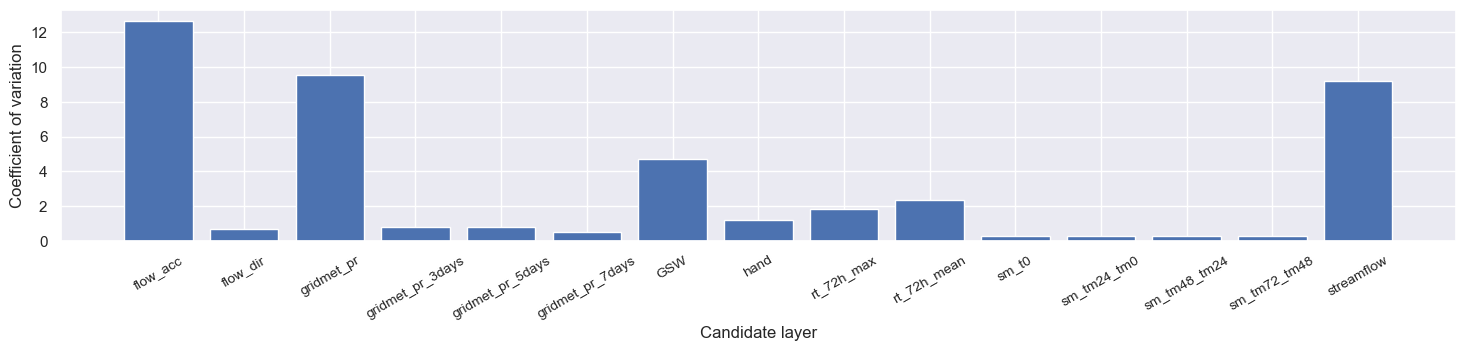

In [47]:
# coefficient of variation
cv_df = df.std() / df.mean()
cv_df = cv_df.reset_index().rename(columns={'index':'layer_name', 0:'cv'})
fig, ax = plt.subplots(figsize=(18,3))

ax.bar(cv_df['layer_name'], cv_df['cv'])
ax.tick_params(axis='x', labelrotation=30, labelsize=10)
ax.set_xlabel('Candidate layer')
ax.set_ylabel('Coefficient of variation')

plt.savefig(f'{data_root}/results/cv.png')
plt.show()


## Task 1-2 A visual summary of quantiles and outliers in each data layer.
One simple and useful method for visually illustrating the quantiles and outliers of each data is boxplot. Here, both boxplot and histrogram were used to show both the quantiles and outliers as well as data distribution for each candidate layer. kurtosis, `kt` and skewness, `sk` of each layer were shown on top of the corresponding histogram. "Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case" [itl.nist.gov](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm#:~:text=Skewness%20is%20a%20measure%20of,relative%20to%20a%20normal%20distribution.).

A normal distribution will have a skewness of 0. Expect one layer, `gridmet_pr_7days` which has skewness close to 0, the rest of the candidates have positive skewness indicating that the size of the right-handed tail is larger than the left-handed tail. It implies most of the data is accumulated in lower values of the total range.

The candidate layers have different situation wrt. the kurtosis. If the kurtosis of the candidate layer is compared with that of normal distribution, which is equal to 3, some candidate layers including `flow_acc`, `gridmet_pr`, `GSW`, `hand`, `rt_72h_max`, `rt_72h_mean`, all soil moisture layers and ` streamflow` have kurtosis greater than 3, indicating heavier tails than a normal distribution (which implies the likelihood of out layers presence). While four other layers including `flow_dir`, `gridmet_pr_3days`, `gridmet_pr_5days`, and `gridmet_pr_7days` have the kurtosis less than 3, implying lighter tails than a normal distribution (less in the tails and fewer out layers).

Finally, Correlation matrix is used to determine if a relationship exists between the variables. The coefficient indicates both the strength of the relationship and the direction (positive vs. negative correlations). Using this matrix dependent variables can be determined. This matrix shows vivid dependency between precipitation fields, NWM routing layers (max and mean), and soil moisture fields.

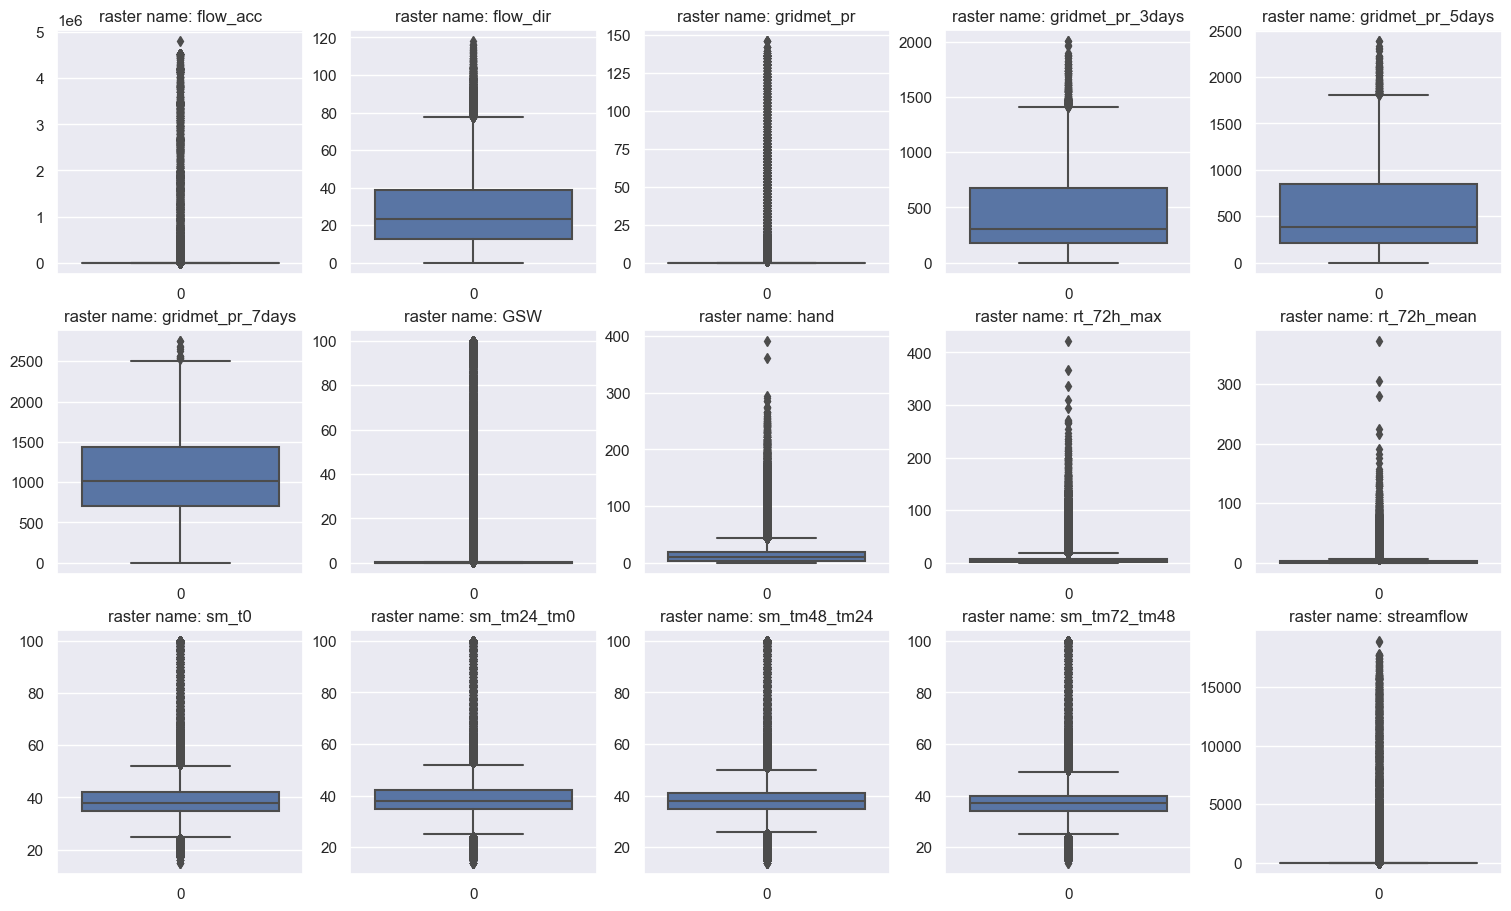

In [114]:
# Boxplot
fig, axes = plt.subplots(nrows=3, ncols=5 , figsize=(15, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df.iteritems()):

    i, j = divmod(index, 5)

    sns.boxplot(data=column_data, orient='v', ax=axes[i, j])
    axes[i, j].set_title(f'raster name: {column_name}')
    axes[i, j].set_xlabel('')

plt.savefig(f'{data_root}/results/boxplots.png')
plt.show()

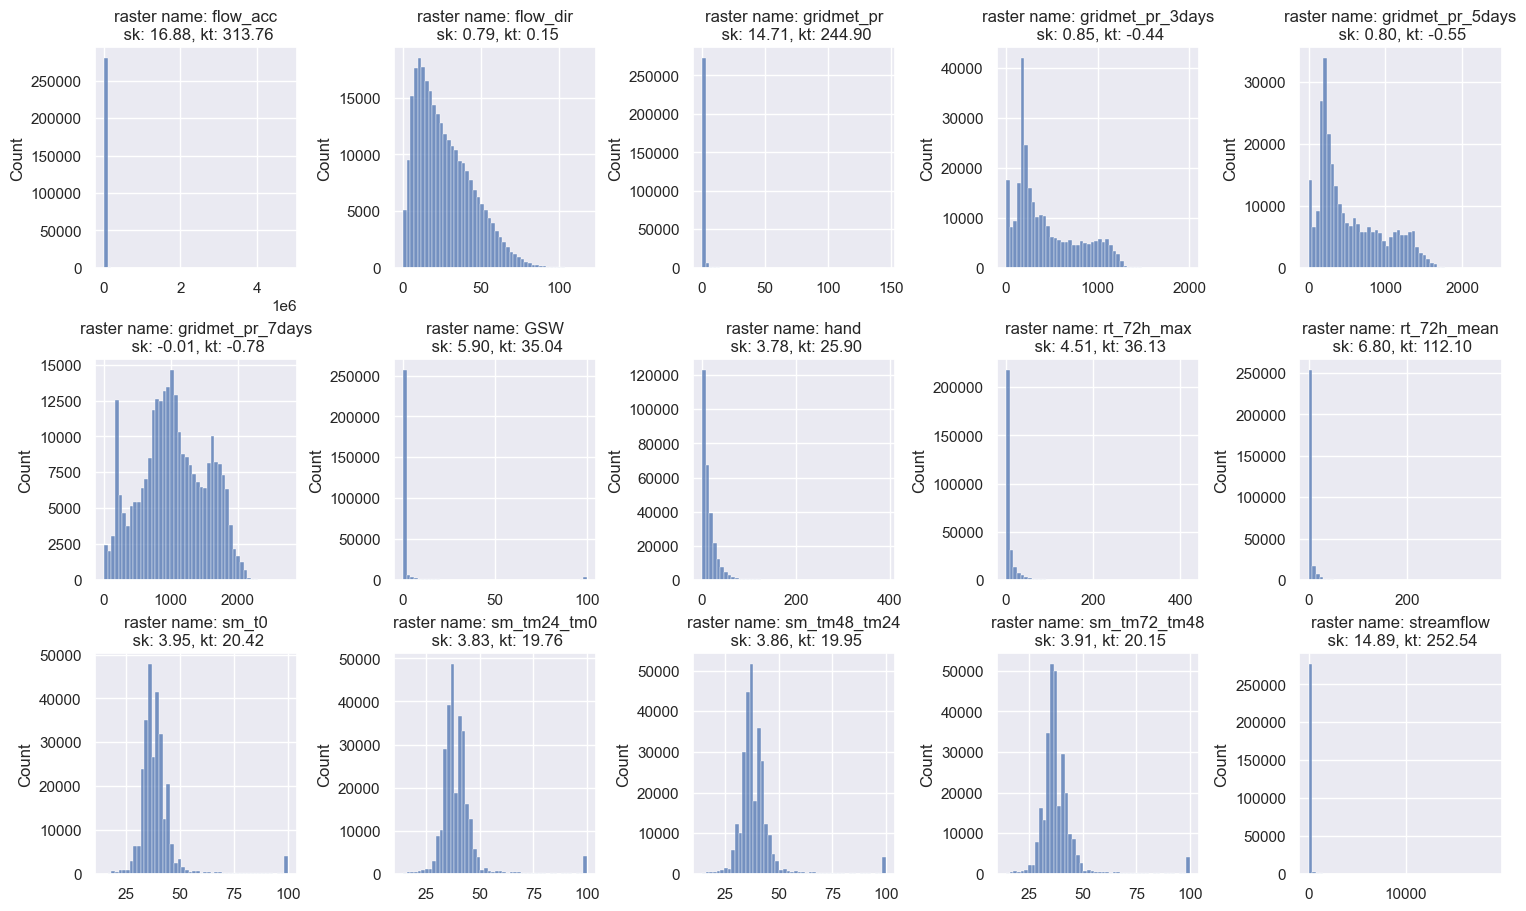

In [48]:
# Histogram
fig, axes = plt.subplots(nrows=3, ncols=5 , figsize=(15, 9), constrained_layout=True)

for index, (column_name, column_data) in enumerate(df.iteritems()):
    i, j = divmod(index, 5)

    sns.histplot(x=column_data.values, bins=50, ax=axes[i, j])
    axes[i, j].set_title(f'raster name: {column_name}\n sk: {skew(column_data.values):.2f}, kt: {kurtosis(column_data.values):.2f}')
    axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/histrograms.png')
plt.show()


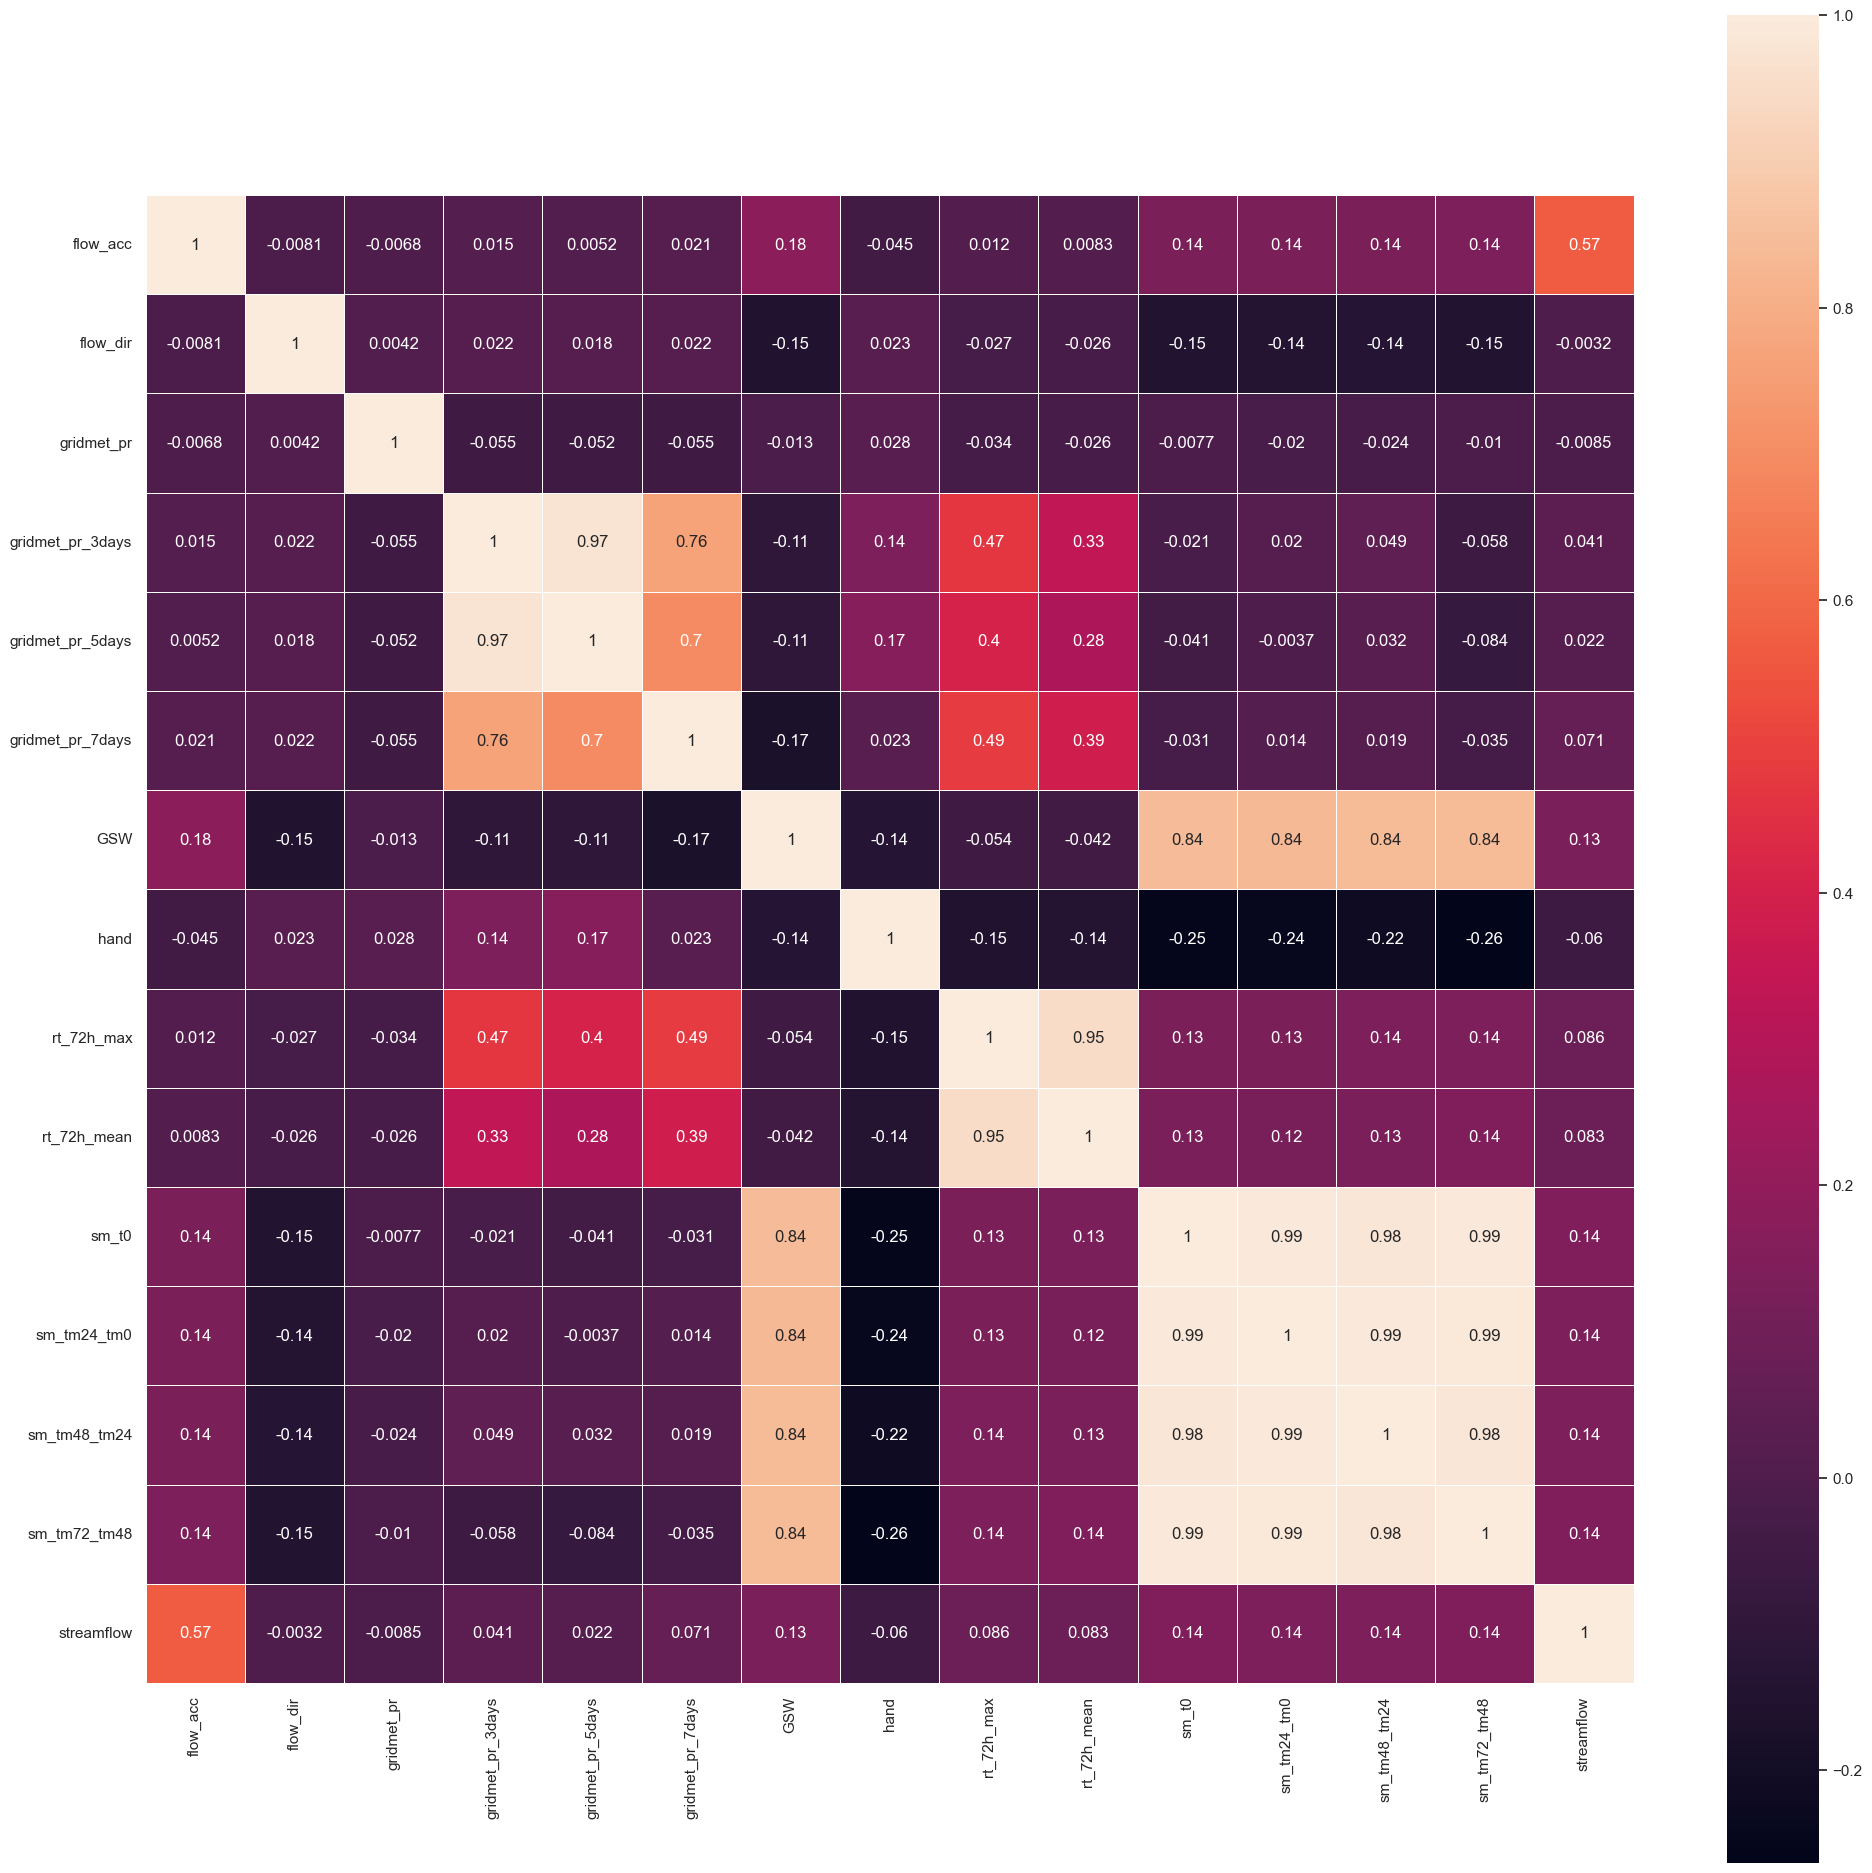

In [23]:
# correlation matrix
corr_mat = df.corr()
fig, ax = plt.subplots(figsize=(24,24))
ax = sns.heatmap(corr_mat, square=True, annot=True, linewidths=.5)
plt.show()

## Task 1-3 Discussion of the merits/drawbacks of these layers.

### 1-3-1 Which data layers appear to have the "richest" information about flooding and why?
Candidate layers are as follows:

#### HAND
HAND stands for the Height Above Nearest Drainage, and it, alone!, can be considered as a conceptual method for flood inundation mapping. `HAND` can be estimated for each catchment by using a digital elevation model (DEM) of the terrain and a spatial representation of a river network (commonly come from National Hydrography Datasets-- NHD). So, by having water stage, HAND can estimate inundation zone and a water depth grid. Water stage can be derived from synthetic rating-curves (to provide different scenarios) or the outcome of **Channel Routing** module of NWM. In NWM, depending on what algorithm is being used-- gridded or linked routing-- physical model (1D Diffusive Wave approximation) or conceptual models (Muskingum or Muskingum-Cunge) can be adopted for performing channel routing. So, `HAND` raster includes rich information for flood as it derived from DEM and river network.

##### References
- Zheng, Xing, et al. "River channel geometry and rating curve estimation using height above the nearest drainage." JAWRA Journal of the American Water Resources Association 54.4 (2018): 785-806.
- Johnson, J. Michael, et al. "An integrated evaluation of the national water model (NWM)–Height above nearest drainage (HAND) flood mapping methodology." Natural Hazards and Earth System Sciences 19.11 (2019): 2405-2420.
- Gochis, D.J., et al. "The WRF-Hydro® modeling system technical description." (2020): Version 5.1.1

#### NWM Routing Previous 72h Mean
For surface overland flow routing, NWM uses a physical model, i.e., 2D diffusive wave approximation formulated by Ogden 1997. It's a good layer to be considered as it includes information of the ponded water depth (surface head) of the grid cells.

##### References
- Gochis, D.J., et al. "The WRF-Hydro® modeling system technical description." (2020): Version 5.1.1

#### NWM Soil Moisture tm72-tm48
Water will pond on the surface only if the rainfall intensity is greater than the infiltration capacity of the soil, the process of water penetrating from the ground surface into the soil. Many factors influence infiltration rate, e.g., condition of the soil surface, and it's vegetation cover, soil properties like porosity and hydraulic conductivity, and finally moisture content of the soil. Moreover, Figure 1 shows how the soil moisture content can affect other factors too.

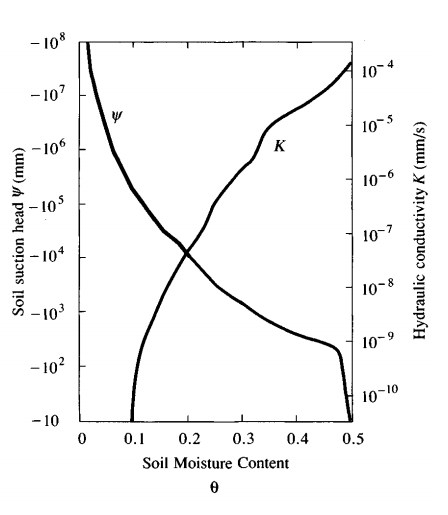
Figure 1. The effect of soil moisture content on hydraulic conductivity.


##### References
- Chow, Ven Te, David R. Maidment, and W. Larry. "Mays. Applied Hydrology." International edition, MacGraw-Hill, Inc 149 (1988).

#### Global Surface Water, Flow Direction, and Flow Accumulation
These three layers, can be useful for embedding the effect of sea level rise and coastal flooding impacts.

### 1-3-2 Which data layers appear to have the "least" amount of information about flooding and why?

#### Precip 1 day sum, Precip 3 day sum, Precip 5 day sum, and Precip 7 day sum
This task does not represent a rainfall-runoff model, and models are not trained to learn rainfall-runoff process. Moreover, the effect of precipitations are physically calculated in NWM Land Surface Module (Noah-MP) and the output results is considered in `NWM Routing Previous 72h Mean` and `NWM Soil Moisture tm72-tm48` layers.

#### NWM Streamflow Linear Interpolation
According to the definition mentioned for this layer, it can be considered a rough representation for riverine flooding. This layer simply implies, the closer grid cell to the stream are more susceptible to flood which conceptually makes sense. But as the other candidate layers (i.e., `NWM Routing Previous 72h Mean`, `hand`) can better represent this layer, and adding further layers, implying on the same phenomenon, might cause bias on the final result, I wouldn't consider this layer.

#### NWM Routing Previous 72h Max
In NWM, the ponded water of the grid cells inflows to the channel whenever it exceeds the retention depth (i.e., the combination of the local infiltration excess, the amount of water flowing onto the grid cell from overland flow, and exfiltration from groundwater flow), so considering maximum values of ponded water for 72 hours might be an overestimation.

##### References
- Gochis, D.J., et al. "The WRF-Hydro® modeling system technical description." (2020): Version 5.1.1

#### NWM Soil Moisture t0, NWM Soil Moisture tm24-tm0, NWM Soil Moisture tm48-tm24
`NWM Soil Moisture tm72-tm48` is better representative compared to other soil Moisture layers as it consists of more temporal information about the moisture content of soil.


## Task 1-4 Potential preprocessing steps you would apply to any of the layers prior to training a model?
  * which layer(s)
  * what transformation(s) and provide examples with code and visualizations where possible
  * What classes of models would the transformation be appropriate for (ex. Random Forests, SVMs, Logistic Regression, Convolutional Networks)

For all layers, Min-Max scaler is applied to transfer the values to the range of [0 1]. Then, Depending on model, further preprocessing can be applied. In the case of ConNets, for example, having pre-trained feature extraction backbone on specific dataset (e.g., pre-trained ResNet on ImageNet), Standard scaler (Z-score) will be applied based on the Mean and STD of the pretrained dataset (ImageNet in this example). This scaler transforms the new dataset into the same data space that the backbone model were trained based upon. In the case of tree-based models (Random Forests, XGBoost, etc.), they don't require scaling as they are invariant to transformations of any input variable. For SVMs, as predictors and target variable has highly skewed distribution, using log transformation 'might' enhance the performance of the models, it should be tested, though.


### Examples for preprocessing the input layers and the effect of transformation on their distribution

In [ ]:
from sklearn.preprocessing import scale, minmax_scale
mscaled_data = minmax_scale(df, feature_range=(0, 1))
mscaled_df = pd.DataFrame(mscaled_data, index=df.index, columns=df.columns)

sscaled_data = scale(df)
sscaled_df = pd.DataFrame(sscaled_data, index=df.index, columns=df.columns)

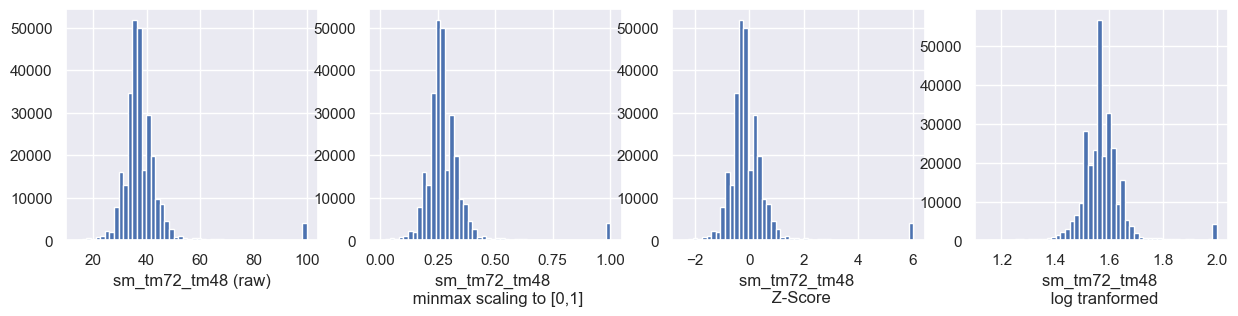

In [22]:
fig, axes = plt.subplots(ncols=4, figsize=(15,3))
axes[0].hist(df['sm_tm72_tm48'], bins=50)
axes[0].set_xlabel('sm_tm72_tm48 (raw)')
axes[1].hist(mscaled_df['sm_tm72_tm48'], bins=50)
axes[1].set_xlabel('sm_tm72_tm48 \n minmax scaling to [0,1]')
axes[2].hist(sscaled_df['sm_tm72_tm48'], bins=50)
axes[2].set_xlabel('sm_tm72_tm48 \n Z-Score')
axes[3].hist(np.log10(df['sm_tm72_tm48']), bins=50)
axes[3].set_xlabel('sm_tm72_tm48 \n log tranformed')

plt.show()

### Floopmaps hisogram
The following code shows the histogram for ground truth flood maps of all six training samples.

In [6]:
dirs_list = [fname for fname in os.listdir('data/') if os.path.isdir(os.path.join('data/', fname))]
targets_path = []
for dir in dirs_list:
    targets_path.append(f'data/{dir}/label/floodmap_v0_11_with_cloudmask.tif')

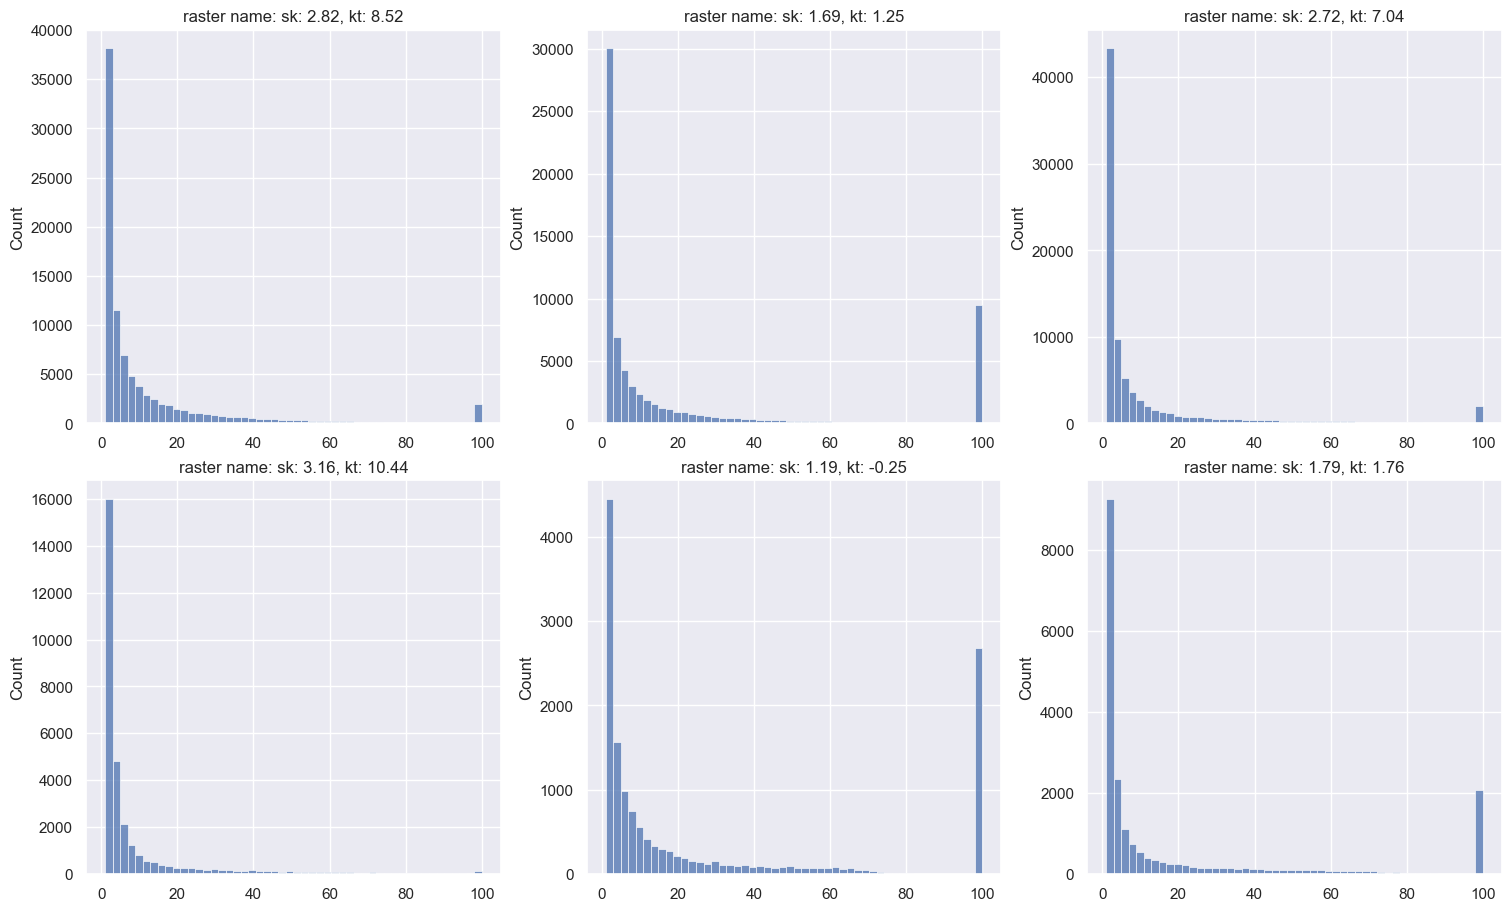

In [16]:
plt.show()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9), constrained_layout=True)

for index, tpath in enumerate(targets_path):
    i, j = divmod(index, 3)
    with rio.open(tpath) as src:
        x = src.read(1)
        # pprint(src.profile) # detailed raster metadata
        x = x.astype(np.float32)
        x[x==src.nodata] = 0
        x = x.ravel()
    x = x[x!=0]
    sns.histplot(x=x, bins=50, ax=axes[i, j])
    axes[i, j].set_title(
        f'raster name: sk: {skew(x):.2f}, kt: {kurtosis(x):.2f}')
    axes[i, j].set_xlabel('')

# plt.savefig(f'{data_root}/results/histrograms.png')
plt.show()

## Task 1-5  additional commentary with considerations for modelling or determining what models are appropriate.
A Regression task can be defined. For this purpose, the ground truth flood map and candidate layers should be flattened and converted to vectors. In this form, for each flood map pixel, we will have a couple of corresponding scalar predictors. RFs, SVMs, and other conventional ML models can be used as a regression model to solve this problem. In this form, the problem is clearly defined, and as the inputs/outputs are vectors it will not be computationally expensive. However, such a framework, will not consider spatial dependency of grid cells as they are considered vector.

A semantic segmentation task can be also defined to deal with this problem. For this purpose a DL-based model should be configured to receive candidate layers as input, encode them into latent features, and eventually decode latent features to final map. Ground truth masks in this problem have 100 classes, representing the fractional flooded area of a grid cell (pixel), and well-trained model will produce maps close to ground truth ones. This model configuration takes the advantage of using spatial information of grid cell, while it is computationally expensive and needs GPUs for parallel processing. Moreover, we can change the loss function from cross entropy to Mean Squared Error to make a regression problem. For this configuration, we might need to change the ConvNet layers (based on my experience, BachNorm layer should be omitted from the architecture).

# Task 2 Model development: how can we improve a model for specific outcomes?

For task 2 I would try to address the second mentioned limitation, which is related to neglecting the impact of coastal storm surge. However, I have some thoughts about urban flooding that I added here.

The spatial resolution of NWM output layers is 1x1km, and 250x250m for soil moisture and train routing layers, respectively, which is too coarse for the case of urban flooding. As these layers are coming from NOAA operational forcasting (i.e., the model does not run and its output products are used), the only method can be used to achieve finer resolution than the native grid is upscaling the gridded cells which I'm not sure if it will be good solution for urban flooding. "imperviousness factor" in the urban areas should be also considered for urban flooding that "land cover/land use" layers can provide good information for this regard. "drainage network" is another parameter which should be considered for urban flooding, however, adjusting the effect of this layer on ponded water is not easy.

In the following markdown cell I've focused on the impact of coastal storm surge.

## Data sources including model inputs and target
### Input layers
- Considering all layers currently exists in the model, the output of ETSS model will be added as the third dynamic inputs. The Extra-Tropical Storm Surge (ETSS) model is developed and maintained by the National Weather Service’s (NWS) Meteorological Development Laboratory (MDL). It runs operationally four times a day to predict overland surge with tide guidance for extra-tropical storms along the U.S. East Coast, Gulf of Mexico, West Coast and all of the coasts of Alaska [1].

- The land cover maps of the Coastal Change Analysis Program (C-CAP) will be also added as the fourth static inputs. C-CAP produces land cover products for coastal regions of the U.S. every five years and can be obtained from the NOAA digital coast repository [2].

### Target flood maps
Flood maps can be generated by two different sources:

1. The advanced circulation model (ADCIRC) provides real-time flood forecasts as well as hindcast flood guidance maps of the Atlantic and Gulf coast through the Coastal Emergency Risk Assessment (CERA) web mapper [3].

2. Using the outputs of coastal compound flooding (CCF) models such as Interconnected Channel and Pond Routing (ICPR) models, Delft3D, and HEC-RAS to generate flood maps [4, 5].

## Modeling structure
As the input layers are gridded cells, CNN-based encoder-decoder segmentation model is one of the most efficient options for generating flood maps. First, static/ dynamic layers are stacked on each other and fed into a ResNet51 backbone to extract features (Note, if upscaling or downscaling is required due to the inconsistency of spatial resolution of input layers, K-Nearest Neighbor will be used to avoid generating artifacts). Atrous Convolutions (rate of 2) are replaced with conventional ones to increase the field of view while keeping the computational cost the constant. This modification also enhances the feature aggregation for achieving prior information of scene context and capturing long-range dependencies in the input layers [6].

As the aim of model is to **generate** fractional water extent maps (authors of paper used "regress" term), a conditioned normalization module, Spatially-Adaptive Normalization, will be borrowed form a CNN-based generative models to normalize the extracted features in each step **conditioned on C-CAP coastal land covermap** [7]. The module formulation is as follows:
$x_i = \gamma \times x_{i-1} + \beta $

Where, $x_{i-1}$ is feature tensor coming from previous block (free from Batch Norm), and $x_i$ is the transformed tensor given C-CAP layer.

## Modeling domain
Input layers first encoded to desired features using backbone feature extraction. The decoder includes, series of conditional normalizaiton (residual) block after each upsampling layer Figure 2 (top). The conditional normalization block is shown in Figure 2 (bottom).

![model_arc.png](attachment:model_arc.png)

## Model output improvements
standard deep network include convolution followed by normalization. Normalization has useful properties such as smoother gradient and invariance to input scaling. However, applying unconditional normalizations (e.g., batch normalization) on semantic-like maps (GSW, flow accumulation and C-CAP, etc.) results in too much invariance and losing the layer information. For example, suppose a large area of input layer has the same values on the gridded cells (uniform value), convolution operation on such an area will produce uniform activation layer which all become zero once they are normalized. In the proposed model, to preserve the layer information, the normalization is implemented given the important static layer (C-CAP, i.e., land cover for coastal regions), which guarantees C-CAP information is not lost.

## References
[1] NOAA MLD: The Meteorological Development Laboratory. *P-ETSS Model*. Retrieved (2022, Dec 9), from `https://vlab.noaa.gov/web/mdl/petss`

[2] NOAA Office for Coastal Management Digital Coast. *C-CAP Land Cover Atlas*. Retrieved (2022, Dec 9), from `https://coast.noaa.gov/digitalcoast/tools/lca.html`

[3] CERA Coastal Emergency Risks Assessment. Retrieved (2022, Dec 9), from `https://cera.coastalrisk.live/`

[4] Muñoz DF, Muñoz P, Moftakhari H, Moradkhani H. *From local to regional compound flood mapping with deep learning and data fusion techniques*. Science of the Total Environment. 2021 Aug 15;782:146927.

[5] Tanim AH, McKinnie W, Goharian E. *Enhanced Simulation of Coastal Compound Flooding through Fully-Coupled Modeling Framework*. ESS Open Archive, from `https://essopenarchive.org/doi/full/10.1002/essoar.10512906.1` . November 22, 2022.

[6] Yuan Y, Huang L, Guo J, Zhang C, Chen X, Wang J. OCNet: Object context for semantic segmentation. International Journal of Computer Vision. 2021 Aug;129(8):2375-98.

[7] Park T, Liu MY, Wang TC, Zhu JY. *Semantic image synthesis with spatially-adaptive normalization*. InProceedings of the IEEE/CVF conference on computer vision and pattern recognition 2019 (pp. 2337-2346).